In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas as pd
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

<span style="color:green"> I refer to the novels targeting male audience as male novels and the novels targeting female audience as female novels. Of course, there is no guarantee that only women read female novels and only men read male novels. But, in qidian's categorizations, there is a place where I can choose "boys" or "girls" (https://www.qidian.com/all). If I click "boys", then the website jumps to "起点中文网"; and if I click "girls", then the website jumps to "起点女生网". The gender differentation is built into the website.

In [4]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

In [5]:

helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)
bookDF_ch["book_gender"]= ["boy"]* 500+ ["girl"]* 500

#Collapse 30 chapters
helper_lis= [] 
for i in range(bookDF_ch.shape[0]):
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_clean"]
    helper_lis+= [cell]
    
bookDF_ch["30_ch_list"]= helper_lis

In [134]:
#Data managing, combining the 30 chapters (of each novel) into one cell and clean out unwanted words
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_tag_clean"]

bookDF_ch_male= bookDF_male_tokenized[helper_col]
bookDF_ch_female= bookDF_female_tokenized[helper_col]
bookDF_ch= pd.concat([bookDF_ch_male, bookDF_ch_female], axis= 0)
bookDF_ch["book_gender"]=  ["boy"]* 500+ ["girl"]* 500


#Collapse 30 chapters (30 columns into one) for male and female version separately
helper_lis= [] 
for i in range(bookDF_ch.shape[0]): 
    cell= []
    cell= []
    for j in range(30):
        cell+= bookDF_ch.iloc[i]["ch"+str(j+1)+"_tag_clean"]
    helper_lis+= [cell]

    
keep_tag= ["a", "ag", "ad", "an", "d", "e",
           "i", "l", "ng", "o",
           "s", "tg", "t", "vg", "v", "vn", "z"]

word= []
for i in range(bookDF_ch.shape[0]):
    cell= []
    for w1, t1 in helper_lis[i]:
        if w1 in ["他", "她"]:
            cell+= [w1]
        elif t1 in keep_tag:
            cell+= [w1]
    word+= [cell]

bookDF_ch["30_ch_list"]= word

In [135]:
#Replace 他 and 她 in the two kinds of novel.
#For the male-novels, 他= male_he, 她= male_she
#For the female-novels, 他= female_he, 她= female_she

def replace_character_maleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["male_he"]
        elif w== "她":
            new_wordlist+= ["male_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]
        
def replace_character_femaleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["female_he"]
        elif w== "她":
            new_wordlist+= ["female_she"]
        else:
            new_wordlist+= [w]
    return [new_wordlist]

bookDF_ch["30_ch_list_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: replace_character_maleN(x)),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: replace_character_femaleN(x))],
                                        axis= 0)
                                        

## <span style="color:purple"> Exercise 1
<span style="color:purple"> Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the social and cultural game underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [7]:
#Default, 5 times training
bookW2V = gensim.models.word2vec.Word2Vec(bookDF_ch["30_ch_list_replace"].sum())

<span style="color:green"> This part is to decide how many epoches I need. 

Done epoch 1
Done epoch 2
Done epoch 3
Done epoch 4
Done epoch 5
Done epoch 6
Done epoch 7
Done epoch 8
Done epoch 9
Done epoch 10
Done epoch 11
Done epoch 12
Done epoch 13
Done epoch 14
Done epoch 15
Done epoch 16
Done epoch 17
Done epoch 18
Done epoch 19
Done epoch 20


//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


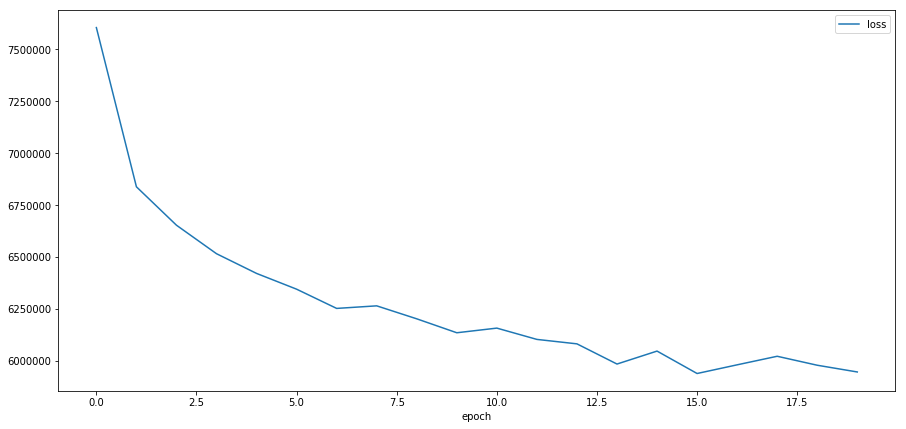

In [136]:
losses=[]
bookW2V_loss = gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                               alpha=0.025,
                                               window=5,
                                               min_count=5,
                                               hs=0,  #hierarchical softmax toggle
                                               compute_loss = True)
bookW2V_loss.build_vocab(bookDF_ch["30_ch_list_replace"].sum())
for i in range(20):
    bookW2V_loss.train(bookDF_ch["30_ch_list_replace"].sum(), 
                       total_examples=bookW2V_loss.corpus_count, 
                       epochs=1)
    losses.append(bookW2V_loss.get_latest_training_loss())#running_training_loss
    print("Done epoch {}".format(i + 1))

lossesDF = pd.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch',logy=False, figsize=(15, 7))
plt.show()

<span style="color:green"> After training for 20 times. I can see that the decrease in train loss slows down. I think 20 epochs seem to be a reasonable amount of iteration. 

<span style="color:green"> I  explore some gender-related characteristics of the fictions.

    In male novels, "she" occurs less frequent than "he" (3 times less frequent!), which means that "she" is probably not the main character in the novels that target on male audience. In female novels, "she" occurs a similar amount of times as "he", meaning that both gender play important roles in novels targeting female audience.

    I look at the top 200 most similar words to "he" and "she" in male and female novels. The pattern confirms the gender stereotypes. "he" is protrayed very differently from "she". 

    Next, I take the first 200 most similar words around the four characters, calculate cosine similarity between each word pair and take an average of the 200*200 cosine scores. In male novels, "she" is associated with more homogeneous words than "he". In the female novels, the homogeneity of the words around "he" and "she" is similar. 
    
    I also tested the "queen= king + man - woman" logic to find the words corresponding to "he" and "she". However, the restuls of this operation are very unstable. If I train the model 20 times, I get very different restuls comparing to training the model 5 times (default). This is understandable becuase finding the most similar words is too specific and any changes in the model can change the restult. My conclusion is that this is interesting and fun. But it's results are not reliable unless I have a list of words that I can use to find the commensurate systematically.
    
<span style="color:green"> The bootstraping generate strange restuls. The cosine estimates of the 20 bootstrap samples are very different from the original one. I have tested it more than one time and double check my code with the example codes. I do not know why... 

In [229]:
#How many times did the four character occurs?
dic_count= {"male_he": 0,
            "male_she": 0,
            "female_he": 0,
            "female_she": 0}

for i in range(len(bookDF_ch["30_ch_list_replace"])):
    b= bookDF_ch["30_ch_list_replace"].iloc[i]
    for w in b[0]:
        if w== "male_he":
            dic_count["male_he"]+= 1
        elif w== "male_she":
            dic_count["male_she"]+= 1
        elif w== "female_he":
            dic_count["female_he"]+= 1
        elif w== "female_she":
            dic_count["female_she"]+= 1

dic_count   

{'female_he': 148773,
 'female_she': 298651,
 'male_he': 250861,
 'male_she': 49675}

In [137]:
print("he in male novel: \n", bookW2V_loss.most_similar("male_he", topn= 200))
print()
print("she in male novel: \n", bookW2V_loss.most_similar("male_she", topn= 200))
print()
print("he in female novel: \n", bookW2V_loss.most_similar("female_he", topn= 200))
print()
print("she in female novel: \n", bookW2V_loss.most_similar("female_she", topn= 200))
print()
#print(senReleasesW2V.doesnt_match["male_he", "male_she", "female_he", "female_she"])

he in male novel: 
 [('female_she', 0.45786333084106445), ('教练', 0.407848596572876), ('female_he', 0.4062231779098511), ('认不', 0.32337355613708496), ('对此', 0.31825435161590576), ('但他却', 0.30925098061561584), ('吃喝玩乐', 0.30393558740615845), ('没教', 0.3007439076900482), ('一无所知', 0.2968454957008362), ('前世', 0.296095073223114), ('上辈子', 0.2951441705226898), ('装傻充愣', 0.2950851321220398), ('糊里糊涂', 0.290949285030365), ('不爱', 0.28677016496658325), ('检举', 0.2831132411956787), ('亏欠', 0.28065910935401917), ('半路出家', 0.2792220413684845), ('一窍不通', 0.27783873677253723), ('怎样才能', 0.27734631299972534), ('自已', 0.2746049165725708), ('知识', 0.2740222215652466), ('家庭出身', 0.2731030583381653), ('唐三', 0.27200937271118164), ('贪财', 0.271005243062973), ('茶余饭后', 0.27002325654029846), ('共同语言', 0.2694830000400543), ('一世', 0.2678681015968323), ('耳濡目染', 0.26772749423980713), ('平平淡淡', 0.2667649984359741), ('练舞', 0.26567113399505615), ('同吃同住', 0.26528531312942505), ('贫困', 0.26477181911468506), ('耕', 0.2637579143047333), ('

In [138]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [139]:
"""Shiyu's note: This is me figuring out whether this function is calculating
similarity or difference. 
I confirm that it is calculating similarity."""
print(cos_difference(bookW2V_loss, "温柔", "温和"))
print(cos_difference(bookW2V_loss, "温柔", "嗤之以鼻"))

[[0.51786196]]
[[-0.01861951]]


In [140]:
def intrinsic_similarity(wordlist):
    np_2dim= np.empty((len(wordlist), len(wordlist)))
    for i in range(np_2dim.shape[0]):
        for j in range(np_2dim.shape[1]):
            np_2dim[i, j]= cos_difference(bookW2V_loss, wordlist[i], wordlist[j])
    return np_2dim

In [141]:
male_he_sim= [w for w, v in bookW2V_loss.most_similar("male_he", topn= 200)]
male_she_sim= [w for w, v in bookW2V_loss.most_similar("male_she", topn= 200)]
female_he_sim= [w for w, v in bookW2V_loss.most_similar("female_he", topn= 200)]
female_she_sim= [w for w, v in bookW2V_loss.most_similar("female_she", topn= 200)]

In [142]:
print("intrinsic similarity around male_he: \n", 
      intrinsic_similarity(male_he_sim).mean())
print("intrinsic similarity around male_she: \n", 
      intrinsic_similarity(male_she_sim).mean())
print("intrinsic similarity around female_he: \n", 
      intrinsic_similarity(female_he_sim).mean())
print("intrinsic similarity around female_she: \n", 
      intrinsic_similarity(female_she_sim).mean())

intrinsic similarity around male_he: 
 0.13960379674929427
intrinsic similarity around male_she: 
 0.1784164985965588
intrinsic similarity around female_he: 
 0.1930747339020949
intrinsic similarity around female_she: 
 0.1833606457034126


In [143]:
print(cos_difference(bookW2V_loss, 'male_he', 'female_he'))
print(cos_difference(bookW2V_loss, 'male_he', 'male_she'))
print(cos_difference(bookW2V_loss, 'female_he', 'female_she'))
print(cos_difference(bookW2V_loss, 'male_she', 'female_she'))

[[0.40622312]]
[[0.19959691]]
[[0.4731263]]
[[0.536035]]


In [144]:
print(bookW2V_loss.most_similar(positive = ['female_he','温柔'], negative = ['female_she'], topn = 1))

[('温和', 0.4507729411125183)]


In [145]:
print(bookW2V_loss.most_similar(positive = ['male_he','害羞'], negative = ['male_she'], topn = 1))

[('吃喝玩乐', 0.3143211305141449)]


In [146]:
print(bookW2V_loss.most_similar(positive = ['male_he','善良'], negative = ['male_she'], topn = 1))

[('有所为有所不为', 0.3707207441329956)]


In [147]:
print(bookW2V_loss.most_similar(positive = ['male_he','贤惠'], negative = ['male_she'], topn = 1))

[('赏识', 0.41883063316345215)]


In [148]:
print(bookW2V_loss.most_similar(positive = ['male_he','吃醋'], negative = ['male_she'], topn = 1))

[('在乎', 0.3832142651081085)]


In [149]:
print(bookW2V_loss.most_similar(positive = ['female_he','撒娇'], negative = ['female_she'], topn = 2))

[('不依', 0.4406299591064453), ('耍赖', 0.40793299674987793)]


In [150]:
print(bookW2V_loss.most_similar(positive = ['male_she','激怒'], negative = ['male_he'], topn = 1))

[('妩媚动人', 0.40606045722961426)]


In [151]:
print(bookW2V_loss.most_similar(positive = ['male_she','后悔'], negative = ['male_he'], topn = 1))

[('妩媚', 0.3648265302181244)]


In [152]:
print(bookW2V_loss.most_similar(positive = ['female_she','欺骗'], negative = ['female_he'], topn = 2))

[('前世', 0.397818922996521), ('现在', 0.3871608078479767)]


In [153]:
print(bookW2V_loss.most_similar(positive = ['male_she','强大'], negative = ['male_he'], topn = 1))

[('柔弱', 0.42818623781204224)]


In [154]:
print(bookW2V_loss.most_similar(positive = ['female_she','做错事'], negative = ['female_he'], topn = 3))

[('不懂事', 0.4375791847705841), ('重活', 0.41903895139694214), ('内疚', 0.41574573516845703)]


<span style="color:green"> Bootstrapping to see how stable the above estimation is.

In [75]:
##Bootstrapping with replacement
s_k_1= []
s_k_2= []
s_k_3= []
s_k_4= []

for x in range(20): #The x here is not used above. Just a way to repeat the operation 20 times
    
    #bookW2VB = gensim.models.word2vec.Word2Vec(bookDF_ch["30_ch_list_replace"].sample(frac=1.0, replace=True).sum())
    bookW2VB = gensim.models.word2vec.Word2Vec(size = 200, #dimensions
                                               alpha=0.025,
                                               window=5,
                                               min_count=5,
                                               hs=0,  #hierarchical softmax toggle
                                               compute_loss = True)
    sampB= bookDF_ch["30_ch_list_replace"].sample(frac=0.6, replace=True).sum()
    bookW2VB.build_vocab(sampB)
    bookW2VB.train(sampB, 
                   total_examples= 1000, 
                   epochs=20)
    try:
        s_k_1.append(cos_difference(bookW2VB, 'male_he', 'female_he')[0,0])
        s_k_2.append(cos_difference(bookW2VB, 'male_he', 'male_she')[0,0])
        s_k_3.append(cos_difference(bookW2VB, 'female_she', 'female_he')[0,0])
        s_k_4.append(cos_difference(bookW2VB, 'male_she', 'female_she')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                    

In [76]:
print(s_k_1)
print(s_k_2)
print(s_k_3)
print(s_k_4)
#This generates results very different from the original ones. 
#Even the sign (+/-) is different.
#I cannot understand why.

[-0.14159998, -0.15353248, -0.12887119, -0.14855212, -0.20093767, -0.14813176, -0.12233892, -0.1446921, -0.17506664, -0.076906234, -0.10233536, -0.12369105, -0.16562621, -0.19504687, -0.21864238, -0.15350905, -0.12587994, -0.12677902, -0.122908235, -0.16256627]
[0.48673204, 0.48039687, 0.5022582, 0.5342021, 0.5383042, 0.4317492, 0.47858396, 0.4509771, 0.5343893, 0.51645577, 0.46300942, 0.49278858, 0.51251787, 0.5153172, 0.49789745, 0.4612226, 0.5096222, 0.50424, 0.5180706, 0.533738]
[0.6567549, 0.60054606, 0.6598858, 0.61746144, 0.65620744, 0.6203268, 0.6866061, 0.6512524, 0.63846076, 0.59458363, 0.5715442, 0.63989055, 0.6663777, 0.6496202, 0.6252638, 0.6369027, 0.6543108, 0.5302937, 0.62789637, 0.61407876]
[0.035165675, 0.040422786, 0.0028875154, -0.00060792454, 0.0015785787, -0.0021180902, 0.049798504, 0.019898802, -0.034407537, -0.028576093, 0.0039907023, 0.016517336, -0.059326585, 0.036456063, -0.028236374, -0.02832999, 0.019878002, 0.018235276, -0.016139846, 0.026264839]


<span style="color:green"> Ploting a scattered cloud. I trie to plot Chinese characters using the external link that TAs provide (https://jdhao.github.io/2017/05/13/guide-on-how-to-use-chinese-with-matplotlib/). But I still could not make it happen. I don't find the cloud particularly informative. For me, Exercise 3 is a more useful visual model.

In [139]:
#For ploting
male_he_sim= [w for w, v in bookW2V_loss.most_similar("male_he", topn= 20)]
male_she_sim= [w for w, v in bookW2V_loss.most_similar("male_she", topn= 20)]
female_he_sim= [w for w, v in bookW2V_loss.most_similar("female_he", topn= 20)]
female_she_sim= [w for w, v in bookW2V_loss.most_similar("female_she", topn= 20)]

targetWords= list(male_he_sim)
numWords= len(targetWords)

In [140]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(bookW2V_loss[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [141]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


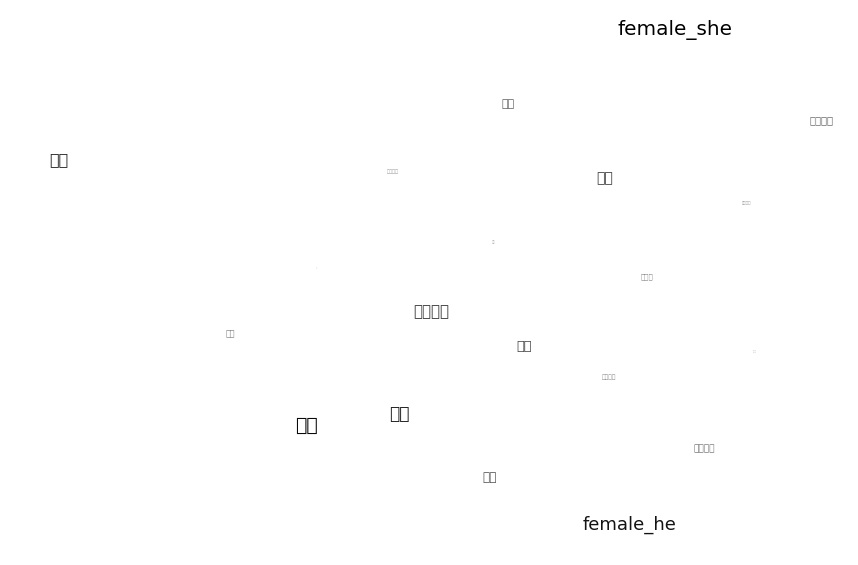

In [157]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)

ax.set_frame_on(False)
font_path = "FangSong.ttf"
prop = mfm.FontProperties(fname=font_path)

plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

##  <span style="color:purple"> Exercise 2

<span style="color:purple">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

<span style="color:pink"> A note to Shiyu: For the purpose of this exercise, when I use POS tags to select words, I ketp "n" (noun), so that things such as "机甲" and "游戏" are retained. But for in general, keeping "n" generates restuls that are less informative.
keep_tag= ["a", "ag", "ad", "an", "d", "e", "i", "l", "ng", "o", "n", "s", "tg", "t", "vg", "v", "vn", "z"]

<span style="color:green"> This exercise is not necessarily helpful for analyzing my corpus. My corpus does not have a clear theme that can be identified by a few keywords. For example, while 仙侠 or 玄幻 are two popular themes, this does not mean that these two words appear in the main text. I arbitrarily come up with a few keywords, but I do not think they capture the content of the novels well. Also, I do not obtain much information from ploting the heatmaps becuase I do not have good keywords nor systematic varaions (such time) to plot with. 

In [68]:
keywords= ["现代", "古代", "修炼", "宫中", 
           "总裁", "机甲", "游戏", "皇上",
           "皇后", "奴婢", "重生", "穿越",
           "玄幻", "领主", "天尊", "神",
           "仙人", "魔", "豪门", "府",
           "虐", "甜"]

In [69]:
taggedDocs = []
i= 0
for index, row in bookDF_ch.iterrows():
    docKeywords = [s for s in keywords if s in row["30_ch_list_replace"][0]]
    docKeywords.append(i)
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row["30_ch_list_replace"][0], tags = docKeywords))
    i+= 1
bookDF_ch['TaggedAbstracts'] = taggedDocs

In [70]:
bookD2V = gensim.models.doc2vec.Doc2Vec(bookDF_ch['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

In [71]:
bookD2V.docvecs[11]

array([-1.1155171e+00, -1.1467651e+00,  7.9097784e-01,  1.4263470e+00,
       -5.3000230e-01, -1.1832881e+00,  2.5366166e-01,  4.6617842e-01,
       -1.4167212e+00, -4.7321728e-01, -1.7846630e+00,  8.3140355e-01,
       -1.6244587e-01,  9.8740405e-01,  1.0269039e+00, -1.4491081e-01,
        3.1993535e-01,  1.1046219e+00, -2.4959780e-02,  5.4289007e-01,
        1.3878640e-02,  6.4188492e-01,  1.3854328e-01,  3.6601605e+00,
       -1.0030669e+00, -1.0099443e+00, -2.4327030e+00, -5.2429283e-01,
        2.2027810e+00, -8.7615550e-01,  1.6590412e-01,  6.0124880e-01,
       -1.8402792e+00,  9.1338795e-01,  1.8809593e+00, -4.1328421e-01,
        4.6799934e-01,  2.5572431e+00, -1.6206881e-01,  6.7054588e-01,
       -1.0751824e+00, -9.0871483e-01,  5.3654224e-01, -4.9708161e-01,
        3.7308016e-01, -2.7125802e+00,  1.0172523e+00,  6.9266641e-01,
       -7.3143417e-01, -1.1647276e+00, -4.2019150e-01, -7.6596759e-02,
        3.0998263e-01,  2.7661104e+00, -3.7537963e+00,  3.2074120e+00,
      

In [72]:
bookD2V["穿越"]

array([-1.036241  ,  4.0010567 ,  0.02261294, -0.6773002 ,  0.39262843,
        2.8891726 , -3.184919  ,  0.4944134 ,  2.974797  , -2.1717992 ,
       -1.9812274 ,  1.0054095 ,  1.0835681 , -2.07533   ,  1.3968008 ,
        0.9056652 , -2.1772127 , -3.2824504 ,  1.2190511 ,  0.54111785,
       -0.7178481 ,  2.3909092 , -0.17335124, -1.3369843 , -0.6619339 ,
       -0.35640058,  2.1047494 ,  0.6734388 , -0.67553145,  0.08581492,
       -1.2816236 , -0.5490736 , -1.297186  ,  0.03499864, -1.5791192 ,
       -2.3625722 ,  2.7228987 ,  1.0689354 ,  0.50509715,  0.9171841 ,
        0.35272798,  1.067422  , -0.16974498,  0.84075165, -4.071526  ,
       -1.4442762 , -0.02616126,  1.8495021 , -0.2213452 , -0.7679084 ,
       -1.3960645 ,  0.9490042 ,  2.3360958 , -5.5621777 ,  1.9834591 ,
       -0.44313717, -5.298339  ,  0.19431332,  5.72587   , -2.939152  ,
        0.90842706, -3.065266  ,  1.9198442 , -1.912186  , -2.2781122 ,
       -1.02624   , -1.5851706 , -0.0820889 ,  1.5303276 ,  3.82

In [73]:
bookD2V.most_similar(positive = ['male_she', '愚蠢'], negative = ['male_he'], topn = 1)

[('善良', 0.6314175128936768)]

In [74]:
names= pd.concat([bookDF_male_tokenized["name"], bookDF_female_tokenized["name"]], axis= 0)
theme_book= bookD2V.docvecs.most_similar([ bookD2V["重生"] ], topn=5 )
for ind, num in theme_book:
    print(ind, names.iloc[ind])

244 变身路人女主
126 贼胆
38 重生完美时代
668 仙姿物语
613 神仙也有江湖


In [75]:
bookD2V.most_similar( [ bookD2V.docvecs[994] ], topn=5) 

[('宅斗', 0.7345486283302307),
 ('牺牲品', 0.7044982314109802),
 ('爱情', 0.7036799192428589),
 ('个人观点', 0.6952002048492432),
 ('大团圆', 0.6883739233016968)]

In [76]:
cross_theme_book= \
bookD2V.docvecs.most_similar([ bookD2V['穿越']+bookD2V['重生']+bookD2V['修炼']], topn=5 )

for ind, num in cross_theme_book:
    print(ind, names.iloc[ind])

381 重生之我为书狂
126 贼胆
38 重生完美时代
244 变身路人女主
613 神仙也有江湖


In [77]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


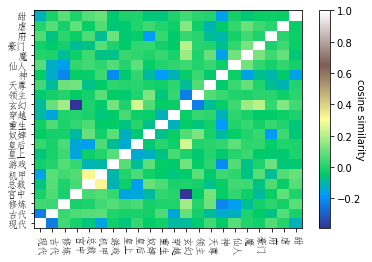

In [78]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

font_path = "FangSong.ttf"
prop = mfm.FontProperties(fname=font_path)

a = ax.set_xticklabels(keywords, minor=False, rotation=270, fontproperties = prop)
a = ax.set_yticklabels(keywords, minor=False, fontproperties = prop)

In [92]:
ind= [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
targetDocs = [i for i in ind]
targetDocs_names= [names.iloc[i] for i in ind]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


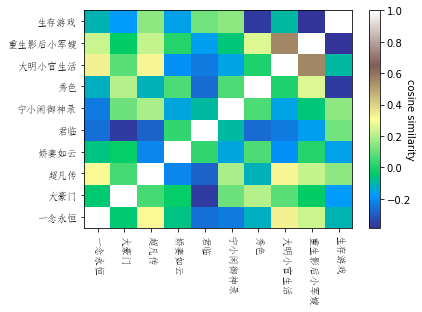

In [93]:
import matplotlib.font_manager as mfm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

font_path = "FangSong.ttf"
prop = mfm.FontProperties(fname=font_path)

a = ax.set_xticklabels(targetDocs_names, minor=False, rotation=270, fontproperties = prop)
a = ax.set_yticklabels(targetDocs_names, minor=False, fontproperties = prop)

In [90]:
heatmapMatrixC = []
ind= [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
targetDocs = [i for i in ind]
targetDocs_name= [names.iloc[i] for i in ind]

for tagOuter in targetDocs:
    column = []
    tagVec = bookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, bookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


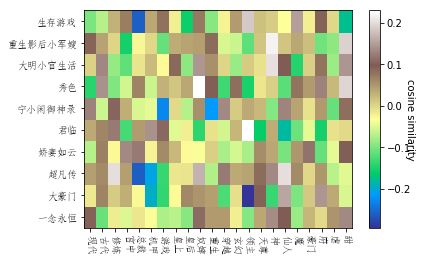

In [91]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

font_path = "FangSong.ttf"
prop = mfm.FontProperties(fname=font_path)

a = ax.set_xticklabels(keywords, minor=False, rotation=270, fontproperties = prop)
a = ax.set_yticklabels(targetDocs_name, minor=False, fontproperties = prop)

<span style="color:green"> The distance between all document and a word of interest: "机甲". I calculat the similarity between the word 机甲 and each novel, then I filter out the novels that are most similar to 机甲. From the index of these selected novel (the first 500 are male novels), I can see that most of the selected novels belong to 'male novel'. 机甲 is a masculine concept.

In [133]:
prox_word_doc= np.empty((1000, 1))
for i in range(1000):
    prox_word_doc[i, 0]= \
    sklearn.metrics.pairwise.cosine_similarity(bookD2V.docvecs[i].reshape(1,-1), 
                                               bookD2V['机甲'].reshape(1,-1))

TF_DF= (prox_word_doc> 0.4)
jijia= []

for i in range(TF_DF.shape[0]):
    if TF_DF[i, 0]== True:
        jijia+= [(i, names.iloc[i])]
jijia   

[(15, '盘龙'),
 (69, '火影之最强震遁'),
 (104, '无敌唤灵'),
 (110, '空速星痕'),
 (146, '魔天记'),
 (151, '小兵传奇'),
 (174, '我们是冠军'),
 (179, '再次飞升'),
 (197, '虚拟战士'),
 (209, '无限恐怖'),
 (262, '重活'),
 (297, '武神空间'),
 (330, '最强黑客'),
 (333, '明血'),
 (337, '终极牧师'),
 (364, '天下'),
 (391, '妖弓'),
 (392, '太古神王'),
 (419, '网游之剧毒'),
 (427, '苍天霸血'),
 (437, '网游之最强房东'),
 (446, '进化的四十六亿重奏'),
 (476, '电影的世界'),
 (488, '佣兵的战争'),
 (489, '邪神传说'),
 (494, '雪洗天下'),
 (497, '超脑黑客'),
 (532, '喜盈门'),
 (570, '庶女攻略'),
 (684, '清朝穿越记'),
 (790, '项链里的空间'),
 (806, '末世涅凰')]

##  <span style="color:purple"> Exercise 3

<span style="color:purple"> Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:green"> I think the most relevant dimension in the novels is gender, so this is the only dimension I plot. I came up with some sentimental adjectives by looking at a Chinese antonym dictionary. Again, "he" and "she" are associated with gender-colored words. 

<span style="color:green"> One thing I find specifically interesting is that "male_he" and "male_she" are the ones stretching the gender dimension. My interpretation is that "male_he" is more exageratively masculine than "female_he"; and "male_she" is more exageratively feminine than "female_she". 

In [93]:
#words to create dimensions
tnytTargetWords = ['male_he', "male_she", "female_he", "female_she"]
#words we will be mapping
tnytTargetWords += ["善良", "冷酷", "温柔", "粗暴", "凶恶", "强大", 
                    "柔软", "坚硬", "纯净", "残暴", "心软", "强硬",
                   "开心", "难过", "痛苦", "欢乐", "悲惨", "幸福", 
                    "嫉妒", "忌妒", "宽恕", "豁达", "贪婪", "惧怕", 
                    "支撑", "轻松", "沉重", "忧伤", "从容", "喜欢", 
                    "灿烂", "动", "静"]
target_dic= {"male_he": "male_he", "male_she": "male_she", "female_he": "female_he", "female_she": "female_she", 
             "善良": "kind", "冷酷": "cold-blooded", "温柔": "gentle", "粗暴": "rude", 
             "凶恶": "fierce", "强大": "strong", "柔软": "soft", "坚硬": "hard", "纯净": "pure", 
             "残暴": "brutal", "心软": "soft-hearted", "强硬": "tough",
             "开心": "happy", "难过": "sad", "痛苦": "painful", "欢乐": "joy", 
             "悲惨": "miserable", "幸福": "hapiness", "嫉妒": "jealous", "忌妒": "envious", 
             "宽恕": "forgive", "豁达": "generous", "贪婪": "greedy", "惧怕": "fear", 
             "支撑": "support", "轻松": "relaxing", "沉重": "heavy", "忧伤": "sorrow", 
             "从容": "unhurried", "喜欢": "like", "灿烂": "glorious", "动": "moving", "静": "still"}


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(bookW2V_loss[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.02293512,  0.36852136, -0.0216776 , ...,  0.05697317,
         0.27015418, -0.24982667],
       [ 0.17908993,  0.1209452 , -0.08993522, ..., -0.1038888 ,
        -0.13519478,  0.83033323],
       [ 0.87270856,  0.25010538,  0.18416354, ..., -0.15319735,
        -0.21723166, -0.03104302],
       ...,
       [ 0.30541295,  0.4621455 , -0.26775205, ..., -0.26728308,
        -0.5651448 ,  1.1884856 ],
       [-0.6171901 ,  0.3085787 ,  0.06366465, ..., -1.6522624 ,
        -0.52101314,  0.7638053 ],
       [ 0.1565732 ,  0.9801629 , -1.2121413 , ...,  3.3088949 ,
        -1.8603109 ,  0.63235104]], dtype=float32)

In [101]:
target_english= [target_dic[w] for w in tnytTargetWords]
print(target_english)

['male_he', 'male_she', 'female_he', 'female_she', 'kind', 'cold-blooded', 'gentle', 'rude', 'fierce', 'strong', 'soft', 'hard', 'pure', 'brutal', 'soft-hearted', 'tough', 'happy', 'sad', 'painful', 'joy', 'miserable', 'hapiness', 'jealous', 'envious', 'forgive', 'generous', 'greedy', 'fear', 'support', 'relaxing', 'heavy', 'sorrow', 'unhurried', 'like', 'glorious', 'moving', 'still']


In [102]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

In [103]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [104]:
gender = dimension(bookW2V_loss, ["male_he", "female_he"], ["male_she", "female_she"])

In [108]:
def makeDF(model, word_list):
    g = []
    
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(bookW2V_loss[word].reshape(1,-1), gender.reshape(1,-1))[0][0])
    
    df = pd.DataFrame({'gender': g}, index = target_english)
    return df

In [110]:
adjectiveDF = makeDF(bookW2V_loss, tnytTargetWords)

In [111]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.flag(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    #ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

//anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


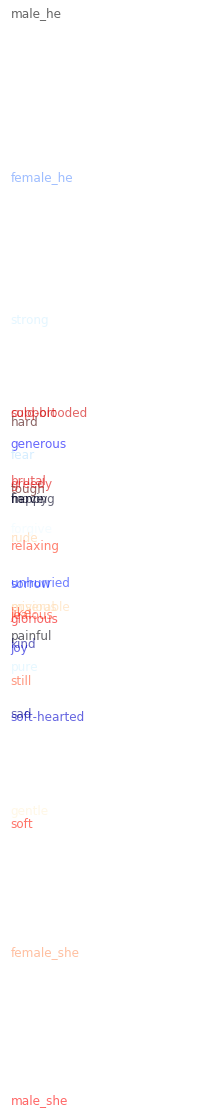

In [113]:
fig = plt.figure(figsize = (12,20))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, adjectiveDF, 'gender')
plt.show()